https://github.com/Neocryan/Amazon-Fine-Food-Recommendation/tree/master

https://www.kaggle.com/code/neocryan/amazon-fine-food-recommendation-system-pmf-svd/notebook

# INTRODUCTION
A very accruate recommendation system
Don't miss it.

# PROBLEM DEFINITION
The problem we are going to solve is how to help users select products which they may like and to make recommendation to stimulate sales and increase profits.
Firstly, we decided to choose the Amazon Fine Food Reviews dataset which consists of 568,454 food reviews Amazon users left up to October 2012 as our dataset.
Secondly, our recommendation system is based on users rating prediction. We assume that users tend to like the products that have a score of greater than 4 and we will consider the highest 5 scores product as our recommendation candidates.
Thirdly, we implemented several algorithms to predict the scores of each product for each user.
![Imgur](https://i.imgur.com/Vu5hasK.png)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/Food.com Dataset/Reviews.csv"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

/content/drive/MyDrive/Food.com Dataset/Reviews.csv



# Data Preprocessing
Here, Take the data which the user and item appear more than 10 times in order to reduce the calculation because we just want to take a small scale test.

The data() function returns the total number of users and products, the user-item table and also the train&test data set.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from main import method0

def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df
def data_clean_sum(df,features,m):
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda x: fil[x])
    df['#Users'] = df.UserId.apply(lambda x: fil2[x])
    while (df.ProductId.value_counts(ascending=True)[0]) < m or  (df.UserId.value_counts(ascending=True)[0] < m):
        df = data_clean(df,features[0],m)
        df = data_clean(df,features[1],m)
    return df

# check if it is correct


def data():
    print('loading data...')
    df = pd.read_csv('/content/drive/MyDrive/Food.com Dataset/Reviews.csv')
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], 10)
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    # Sepreate the features into three groups
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score
    # train_test split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    # got the productId to pid index
    pid2PID = raw_data.ProductId.unique()

    data_mixed = X1.join(y)
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    # make the user-item table
    table = np.zeros([total_u,total_p])
    z = np.array(data_mixed)
    for line in z:
        u,p,s = line
        if table[u][p] < s:
            table[u][p] = s #if some one score a single thing several times
    print('the table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_p,pid2PID,train,test,table,raw_data

z, total_u,total_p,pid2PID,train,test,table,raw_data = data()




loading data...
the table's shape is:
(3666, 1102)


# Evaulation
MSE and confusion matrix

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def caculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0


import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, classes=['not','recommand'], normalize=True,
                          title=title)
    plt.show()


# Randon Forest Regressor
At the very first, we try to use rfr to build a simple model. The idea is very easy, just use the algorithm find the latent score of one pair of user and item. We can see the MSE is not very high, and the confusion matrix is acceptable.
![Imgur](https://i.imgur.com/T4LvkPh.jpg)
This part, the X are uid, pid,time, number of item and user. y is the score.

But the drawback is very obvious: the test MSE is 0.34 and and train MSE is 0.07 -- overfitting is quite a deal.

train MSE is (0.052789918274458975, 0.3093824618545479), test MSE is 0.3093824618545479
accrucy of recommandtion:
0.8573722930266293
accrucy of not recommandtion:
0.964511449590716
Normalized confusion matrix
[[0.92 0.08]
 [0.16 0.84]]


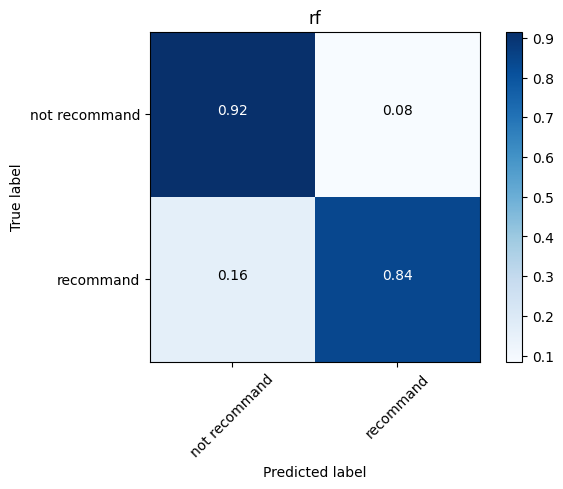

RandomForestRegressor()

In [ ]:
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
def rf():
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))

    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score

    from sklearn.model_selection import train_test_split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    a=RandomForestRegressor()
    a.fit(X3_train,y_train)
    y3 = a.predict(X3_test)
    sc = MinMaxScaler(feature_range=(1,5))
    c = mean_squared_error(y_train,a.predict(X3_train)), mean_squared_error(y_test,sc.fit_transform(y3.reshape(-1,1)))
    b = mean_squared_error(y_test,y3)
    print('train MSE is {}, test MSE is {}'.format(c,b))

    c3 = y3>=4
    t = y_test>=4
    print('accrucy of recommandtion:')
    print(accuracy_score(t,c3))
    c31 = y3<=1
    t1 = y_test<=1
    print('accrucy of not recommandtion:')
    print(accuracy_score(t1,c31))
    y_pred3 = []
    y_test3 = []
    for i in range(y3.shape[0]):
        if y3[i]>=4:
            y_pred3.append(1)
        elif y3[i]<4:
            y_pred3.append(0)
        # else:
            # y_pred3.append(1)

    for j in range(y3.shape[0]):
        if np.array(y_test)[j]>=4:
            y_test3.append(1)
        elif np.array(y_test)[j]<4:
            y_test3.append(0)
        # else:
            # y_test3.append(1)
    import itertools
    import matplotlib.pyplot as plt
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(y_test3,y_pred3)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='rf')


    plt.show()
    return a
rf()

# Recommendation function

In [ ]:
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N

# Distance Based Model
Here we use the cosine-distance to give the similarity between vectors. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The similarity ranges from -1 to 1 where -1 means exactly opposite, 1 means exactly the same and in-between values indicating intermediate similarity or dissimilarity.
![Imgur](https://i.imgur.com/NgxyUjt.png)
Since the MSE of traditional Collaborative Filtering model is quite high, we decided to use quasi-SVD approach instead. In this method, the output matrix is the dot product of three matrix. Here U is user similarity matrix and P is product similarity.
![Imgur](https://i.imgur.com/AmSozCI.png)


the in sample MSE = 2.1815326081122333 
the out sample MSE = 2.2582779695854374
caculating cm..
Normalized confusion matrix
[[0.42 0.58]
 [0.34 0.66]]


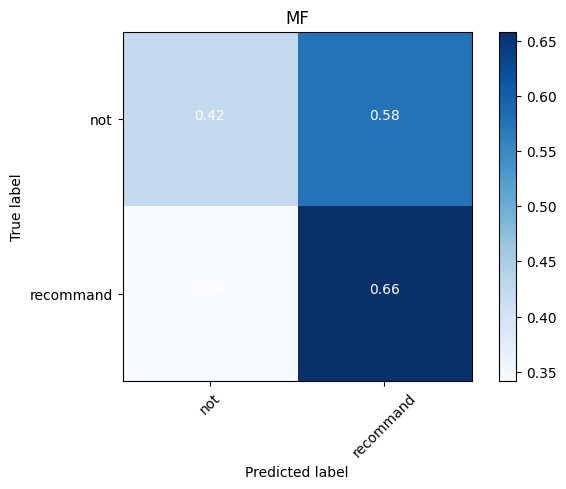

the top10 recommanded products for user 10 is [ 644  151  455   52 1072 1051  127 1067  106    0]
the real ID is ['B0058AMYTC' 'B00472I5A4' 'B0058AMY10' 'B0058AMY74' 'B001SAXPEO'
 'B006WYSFZK' 'B000G6MBUA' 'B004728MI4' 'B0012XBD7I' 'B000G6RYNE']


array([ 644,  151,  455,   52, 1072, 1051,  127, 1067,  106,    0])

In [ ]:

from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a
result =cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 10,10,rawId= True)

The advantage is that this method is quite interpretable. However, the drawbacks are also apparent: this algorithm is naive with a deficient performance. For a large data set, this algorithm need m2+n2 times to calculate the similarity matrix.


# SVD
In our recommendation system, we have such a matrix which has many scores from the users to the items. We hope to predict the targeted users’ score to other unevaluated items and then recommend the items with the highest five scores.
The advantage of SVD is that: users’ score matrix is a sparse matrix, so we can map the original data into a Low-dimensional space and then calculate the similarity of different items. This can help us reduce calculation complexity.
![Imgur](https://i.imgur.com/EYTpKTh.png)



the in sample MSE = 0.3982335596954266 
the out sample MSE = 0.3981359720958576
caculating cm..
Normalized confusion matrix
[[0.96 0.04]
 [0.15 0.85]]


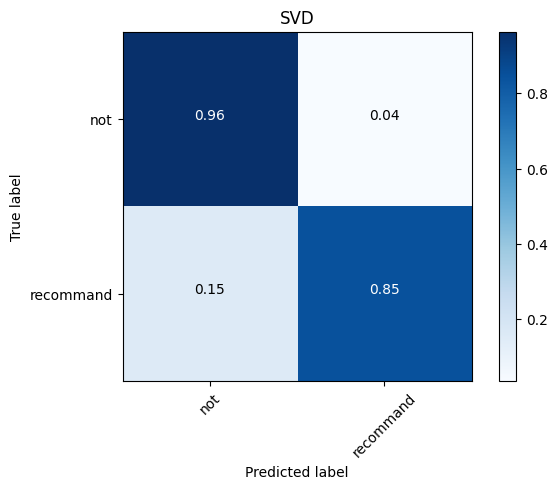

the top10 recommanded products for user 10 is [1067  644  455  967  106  799  127 1051  151   52]
the real ID is ['B004728MI4' 'B0058AMYTC' 'B0058AMY10' 'B000LKVD5U' 'B0012XBD7I'
 'B0058AMY5G' 'B000G6MBUA' 'B006WYSFZK' 'B00472I5A4' 'B0058AMY74']


array([1067,  644,  455,  967,  106,  799,  127, 1051,  151,   52])

In [ ]:
from numpy import *
from scipy.sparse.linalg import svds
from numpy import linalg as la
from sklearn.preprocessing import MinMaxScaler

def svdrec(table=table, factors=150):
    # Convert the table to a numpy array
    UI = np.asarray(table)
    user_ratings_mean = mean(UI, axis=0)
    user_ratings_mean = user_ratings_mean.reshape(1, -1)
    UI_demeaned = UI - user_ratings_mean
    U, sigma, Vt = svds(UI_demeaned, factors)
    sigma = diag(sigma)
    pred_mat = dot(dot(U, sigma), Vt) + user_ratings_mean
    sc = MinMaxScaler(feature_range=(1, 5))
    pred_mat = sc.fit_transform(pred_mat)
    return pred_mat

# Assuming you have a table variable defined somewhere in your code
# result1 = svdrec(factors=150)
# caculate_mse(result1)
# drawcm(result1, title='SVD')
# rec(result1, 10, 10, rawId=True)

def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
result1 =svdrec(factors=150)
caculate_mse(result1)
drawcm(result1,title='SVD')
rec(result1, 10,10,rawId= True)

Not so good, not so bad.

# Matrix Factorization
Latent factor models are an alternative approach that tries to explain the ratings by characterizing both items and users on, say, 20 to 100 factors inferred from the ratings patterns. For products, the discovered factors might measure obvious dimensions such as candy vs drinks, or adult food vs children’s; For users, each factor measures how much the user likes the product that score high on the corresponding movie factor.
Using latent factor model, we transform the way to calculate the similarity of users and products. The features become more stable and condense.

we first create two new metrics, user-latent_factor and product-latent_factor. The size are q*f and p*f, p, q are the total number of users and products, f is the number of latent factors. So, every element in the target matrix can be calculate as:  And the target matrix is shown as  . Next, we need to create the objective function based on least-square method to minimize the loss:
![Imgur](https://i.imgur.com/GlO6Pbo.png)


The system adjusts the model by fitting the previously observed ratings. However, the goal is to generalize those previous ratings in a way that predicts the unknown ratings. Thus, the system should avoid overfitting the observed data by regularizing the learned parameters by adding L2 term. The constant λ controls the extent of regularization and is usually determined by cross-validation.
Next, we use stochastic gradient descent to optimize the objective function. The processing is:
![Imgur](https://i.imgur.com/46ftTCS.png)
Where gamma is the stochastic learning rate and e is the error term. In the iteration, when the change in loss is larger than 0, the learning rate increases by 5%; if delta-loss is smaller than 0, it means the new loss is becoming larger. The learning rate decreases by 50% so that the loss can converge.

iter = 1, loss = 3284.2978692501524, delta_loss = -3284.2978692501524, LR = 0.02
iter = 2, loss = 959.5257777130465, delta_loss = 2324.772091537106, LR = 0.01
iter = 3, loss = 621.9676771289978, delta_loss = 337.5581005840487, LR = 0.0105
iter = 4, loss = 574.3442570838644, delta_loss = 47.62342004513346, LR = 0.011025000000000002
iter = 5, loss = 540.2331839616636, delta_loss = 34.111073122200764, LR = 0.011576250000000003
iter = 6, loss = 505.4888426097779, delta_loss = 34.74434135188568, LR = 0.012155062500000004
iter = 7, loss = 466.6270577431978, delta_loss = 38.86178486658014, LR = 0.012762815625000005
iter = 8, loss = 424.4482075743884, delta_loss = 42.17885016880939, LR = 0.013400956406250006
iter = 9, loss = 381.2725690842803, delta_loss = 43.1756384901081, LR = 0.014071004226562506
iter = 10, loss = 338.8427936673632, delta_loss = 42.429775416917096, LR = 0.014774554437890632
iter = 11, loss = 298.2791538288156, delta_loss = 40.5636398385476, LR = 0.015513282159785164
iter = 

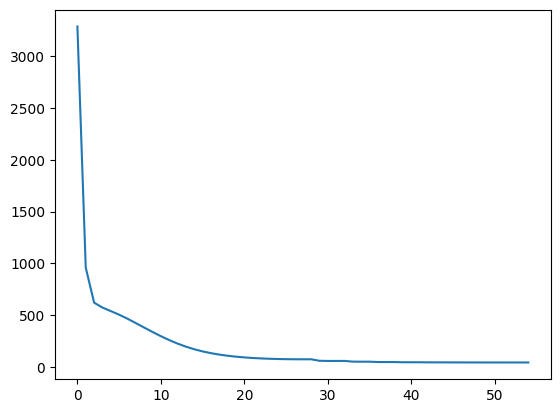

the in sample MSE = 0.03531066886378868 
the out sample MSE = 0.033767502808872335
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.14 0.86]]


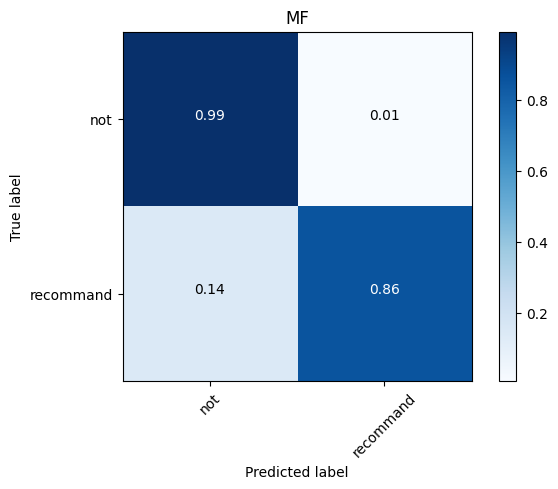

the top10 recommanded products for user 10 is [ 448  256  243 1093  729   96  201  182  996  155]
the real ID is ['B001LNTY70' 'B004HOQE64' 'B001KVPBS4' 'B004HOSGWE' 'B000ZSZ5S4'
 'B004HOLD92' 'B001EQ4QJK' 'B004HOLD4W' 'B004HOLD60' 'B001EQ4RBM']


array([ 448,  256,  243, 1093,  729,   96,  201,  182,  996,  155])

In [ ]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    # initial the latent matrix for user and item
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    # initial y as the history of loss
    y = []
    # initial the iteration and last loss
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            # get the uid,pid and the score from every line
            u, p, s = data[i]
            # calculate the error
            error = s - np.dot(P[u], Q[p])
            # calculate the loss function
            # avoid loss become to large, scale to 1/50
            loss += error ** 2 / 50
            # update the parameter according to the gradient descent
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        # update the learn rate to make sure it will converge
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        # When converge, stop the gradient descend
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

result =MF1( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)

The MF gives a very good prediction: the train set MSE is 0.03542 and the test set MSE is 0.03385. While both MSEs are equally small, thus no overfitting problem occurs.

In addition, as image shows that the number of latent factors significantly affects the results.
![Imgur](https://i.imgur.com/FxdJfsB.png)
As the number of latent factors increase, the MSE decreases. And MSE converges around n=20.  

# Probabilistic Matrix Factorization
![Imgur](https://i.imgur.com/AW7ViEl.png)
PMF is similar to MF. It is nothing more than a MF assuming the distribution of user and production are Gaussian. That is:
![Imgur](https://i.imgur.com/2Qs55Zx.png)


And the joint distribution of user and product is the distribution of the scores.
![Imgur](https://i.imgur.com/83cw1vR.png)

The problem comes to maximum the probability of U, V based on R and variance. This transformation is based on Bayesian formula. Rewrite the function above and applying log to both sides:
![Imgur](https://i.imgur.com/C6IQjeq.png)

When optimizing this function, the standard errors are fixed, so the objective function is:
![Imgur](https://i.imgur.com/zY6LXaj.png)
Gradient descent process is the same with basic MF.
PMF does better than MF for sparse matrices. The assumption of Gaussian makes it more accurate to predict. But for our dataset, the chosen data is not sparse, so the performance of PMF is almost the same with MF.


iter = 1, loss = 3492.215715484706, delta_loss = -3392.215715484706, LR = 0.02
iter = 2, loss = 1113.503219088774, delta_loss = 2378.7124963959322, LR = 0.01
iter = 3, loss = 791.1393889092346, delta_loss = 322.36383017953926, LR = 0.0105
iter = 4, loss = 746.6559359545872, delta_loss = 44.48345295464742, LR = 0.011025000000000002
iter = 5, loss = 716.4903973679341, delta_loss = 30.165538586653156, LR = 0.011576250000000003
iter = 6, loss = 686.5185187794607, delta_loss = 29.971878588473373, LR = 0.012155062500000004
iter = 7, loss = 652.7202591752693, delta_loss = 33.798259604191344, LR = 0.012762815625000005
iter = 8, loss = 615.1236506808784, delta_loss = 37.59660849439092, LR = 0.013400956406250006
iter = 9, loss = 575.8958550868836, delta_loss = 39.22779559399487, LR = 0.014071004226562506
iter = 10, loss = 537.214254407202, delta_loss = 38.68160067968154, LR = 0.014774554437890632
iter = 11, loss = 500.46564996332245, delta_loss = 36.74860444387957, LR = 0.015513282159785164
iter

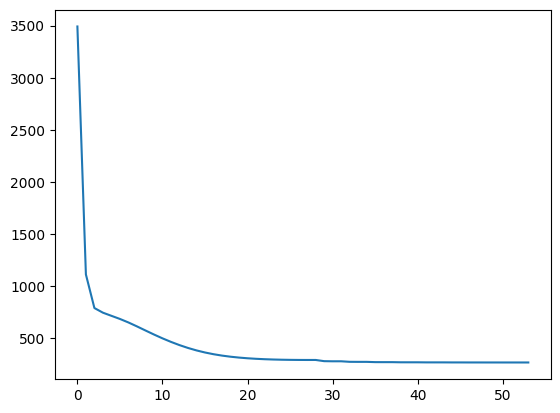

the in sample MSE = 0.037870251385208366 
the out sample MSE = 0.036328498738706826
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.19 0.81]]


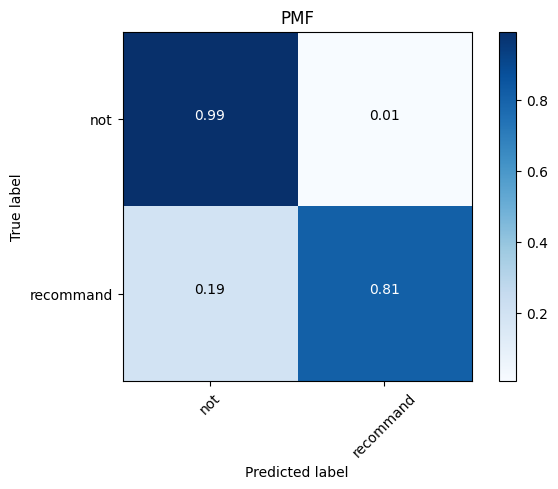

the top10 recommanded products for user 10 is [243 858 729 504 624 969 905 607 837 512]
the real ID is ['B001KVPBS4' 'B000EVIDWW' 'B000ZSZ5S4' 'B003G52BN0' 'B007TJGY5K'
 'B000HDK0DC' 'B001CWX7EG' 'B000EVG8HY' 'B000EVG8FQ' 'B000H7LVKY']


array([243, 858, 729, 504, 624, 969, 905, 607, 837, 512])

In [ ]:
def PMF(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    y = []
    iteration = 0
    last_loss = 100
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2/50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate *  (error * qq - regU*pp)
            Q[p] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)
result =PMF( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='PMF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)

# Some other things
We can find that the MF and PMF did a good job. And the recommendtion they make are also very reasonable.

For example, the 10th user called 'G Little Value Seeker'. Based on what he bought, the chips, chocolate and tea we recommend him starbuck coffee and some dark chocholate -- Mr. ValueSeeker has not bought these, but I am sure he will like them!
![Imgur](https://i.imgur.com/rZnqP2g.png)

Claude:
Stacked LSTM and Autoencoder

https://www.sciencedirect.com/science/article/pii/S2665917423003112#abs0010

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Food.com Dataset/Reviews.csv')

# Encode user and product IDs as integers
user_ids = data['UserId'].unique().tolist()
user_encoded = {x: i for i, x in enumerate(user_ids)}
data['UserId'] = data['UserId'].map(user_encoded)

product_ids = data['ProductId'].unique().tolist()
product_encoded = {x: i for i, x in enumerate(product_ids)}
data['ProductId'] = data['ProductId'].map(product_encoded)

# Create sequences of user interactions
user_sequences = data.groupby('UserId')['ProductId'].apply(list)

# Convert user_sequences to a list
user_sequences = user_sequences.tolist()

# Split into training and test sets
#train_sequences = [seq for seq in user_sequences if len(seq) > 0]
#test_sequences = [seq for seq in user_sequences if len(seq) == 0]

# Shuffle the data
np.random.shuffle(user_sequences)

# Split into training and test sets
train_sequences, test_sequences = train_test_split(user_sequences, test_size=0.2, random_state=42)

# Ensure there are no empty sequences in train_sequences
train_sequences = [seq for seq in train_sequences if len(seq) > 0]

# Create target data by shifting the sequences by one step
#train_targets = [seq[1:] + [0] for seq in train_sequences] # Pad with 0 at the end

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense # Add this line
from tensorflow.keras.models import Model # Ensure this is also imported for Model class

# Set input parameters
max_users = len(user_ids)
max_products = len(product_ids)
embedding_size = 128
lstm_units = 64
num_lstm_layers = 2
max_sequence_length = max(len(seq) for seq in train_sequences)

# Pad sequences to have the same length
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Create target data by shifting the sequences by one step
train_targets = [seq[1:] + [0] for seq in train_sequences]  # Pad with 0 at the end
test_targets = [seq[1:] + [0] for seq in test_sequences]

# Pad the target sequences with the same length as input sequences
train_targets = pad_sequences(train_targets, maxlen=max_sequence_length, padding='post')
test_targets = pad_sequences(test_targets, maxlen=max_sequence_length, padding='post')

In [ ]:
print("Number of training sequences:", len(train_sequences))
print("Number of training targets:", len(train_targets))

Number of training sequences: 204847
Number of training targets: 204847


In [ ]:
print("Example padded sequence:", train_sequences[0])
print("Example padded target:", train_targets[0])

Example padded sequence: [ 1073 19875 46545 48197 71295     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

In [ ]:
# Print a few examples of raw sequences and targets
print("Example raw sequence:", train_sequences[0])
print("Example raw target:", train_targets[0])

# After padding, print a few examples
print("Example padded sequence:", train_sequences[0])
print("Example padded target:", train_targets[0])

Example raw sequence: [ 1073 19875 46545 48197 71295     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     

In [ ]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding = Embedding(max_products + 1, embedding_size)(input_layer)

# Stacked LSTM layers
lstm_layers = embedding
for _ in range(num_lstm_layers):
    lstm_layers = LSTM(lstm_units, return_sequences=True)(lstm_layers)

# Output layer for next-item prediction
output_layer = Dense(max_products + 1, activation='softmax')(lstm_layers)

# Build the model
stacked_lstm_model = Model(inputs=input_layer, outputs=output_layer)
stacked_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
stacked_lstm_model.fit(train_sequences, train_targets, epochs=1, batch_size=16, validation_data=(test_sequences, test_targets))

   47/12803 [..............................] - ETA: 59:22:52 - loss: 9.0020 - accuracy: 0.9759

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, dot, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set input parameters
#max_sequence_length = max(train_sequences.apply(len))

# Set input parameters
max_sequence_length = np.max(np.array([len(seq) for seq in train_sequences]))
attention_units = 32

max_products = len(product_ids) # Assuming product_ids is defined earlier
embedding_size = 128 # Example value, adjust based on your needs

# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding = Embedding(max_products + 1, embedding_size)(input_layer)

# Attention layer
# Adjust the Dense layer to output a tensor with the same last dimension as the embedding size
attention_probs = Dense(embedding_size, activation='softmax')(embedding)
#attention_probs = Dense(attention_units, activation='softmax')(embedding)
attention_mul = Lambda(lambda x: x[0] * x[1])([embedding, attention_probs])
user_embedding = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_mul)

# Decoder layer
item_embedding = Embedding(max_products + 1, embedding_size)(input_layer)

#rating_scores = dot([user_embedding, item_embedding], axes=1)

# Compute the dot product between the user embedding and each item embedding in the sequence
# This is done by expanding the dimensions of the user embedding to match the item embeddings
user_embedding_expanded = tf.expand_dims(user_embedding, axis=1)
rating_scores = dot([user_embedding_expanded, item_embedding], axes=2)

# Sum the scores across the sequence
rating_scores = Lambda(lambda x: tf.reduce_sum(x, axis=1))(rating_scores)

# Apply the sigmoid activation to get the final rating scores
rating_scores = Activation('sigmoid')(rating_scores)

# Build the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=rating_scores)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
#autoencoder.fit(train_sequences, epochs=1, batch_size=16, validation_data=test_sequences)


# Assuming train_sequences and test_sequences are lists of sequences
# Convert them to NumPy arrays
train_sequences_np = np.array(train_sequences)
test_sequences_np = np.array(test_sequences)

# Encode and pad the sequences
train_sequences_encoded = pad_sequences(train_sequences_np, maxlen=max_sequence_length, padding='post')
test_sequences_encoded = pad_sequences(test_sequences_np, maxlen=max_sequence_length, padding='post')

# Now, you can pass these encoded and padded sequences to the fit method
#autoencoder.fit(train_sequences_encoded, epochs=1, batch_size=16, validation_data=(test_sequences_encoded, None))

# Use the input data as the target data for training
autoencoder.fit(train_sequences_encoded, train_sequences_encoded, epochs=1, batch_size=16, validation_data=(test_sequences_encoded, test_sequences_encoded))


In [ ]:
# Obtain user and item embeddings from the trained models
user_embeddings = stacked_lstm_model.get_layer('user_embedding').output
item_embeddings = autoencoder.get_layer('item_embedding').weights[0]

# Compute similarity scores between user and item embeddings
similarity_scores = dot([user_embeddings, item_embeddings], axes=1)

# Build the final recommendation model
input_layer = Input(shape=(max_sequence_length,))
output_layer = dot([stacked_lstm_model.output, similarity_scores], axes=1)
recommendation_model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from sklearn.metrics import precision_score, recall_score, ndcg_score

# Evaluate the recommendation model on the test set
test_scores = recommendation_model.predict(test_sequences)
top_k_predictions = np.argsort(test_scores, axis=1)[:, -5:]  # Top 5 predictions

# Calculate evaluation metrics
true_labels = test_sequences.apply(lambda x: x[-1]).values
precision = precision_score(true_labels, top_k_predictions, average='samples')
recall = recall_score(true_labels, top_k_predictions, average='samples')
ndcg = ndcg_score(true_labels, test_scores, k=5)

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"NDCG@5: {ndcg:.4f}")

# Recommend top 5 products for a given user
user_id = ABXLMWJIXXAIN  # Replace with the desired user ID
user_sequence = user_sequences.loc[user_id]
recommendations = recommendation_model.predict(np.array([user_sequence]))
top_product_ids = np.argsort(recommendations[0])[-5:]
top_products = [product_ids[idx] for idx in top_product_ids]
print(f"Top 5 recommended products for user {user_id}: {top_products}")